In [22]:
import pandas as pd
import numpy as np
import time
from tqdm import tqdm
import seaborn as sns
from textblob import TextBlob
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('msmarco-distilbert-base-dot-prod-v3')

✅ Elasticsearch security features have been automatically configured!
✅ Authentication is enabled and cluster connections are encrypted.

ℹ️  Password for the elastic user (reset with `bin/elasticsearch-reset-password -u elastic`):
  PS3sL=z_eXnb0Nf7No5c

ℹ️  HTTP CA certificate SHA-256 fingerprint:
  f47cade795587ed56e7ad87c37b32db53b4f61941fdb3ea4a27f58c09a00657a

ℹ️  Configure Kibana to use this cluster:
• Run Kibana and click the configuration link in the terminal when Kibana starts.
• Copy the following enrollment token and paste it into Kibana in your browser (valid for the next 30 minutes):
  eyJ2ZXIiOiI4LjEwLjQiLCJhZHIiOlsiMTcyLjIxLjAuMjo5MjAwIl0sImZnciI6ImY0N2NhZGU3OTU1ODdlZDU2ZTdhZDg3YzM3YjMyZGI1M2I0ZjYxOTQxZmRiM2VhNGEyN2Y1OGMwOWEwMDY1N2EiLCJrZXkiOiJSRTRLYm9zQnVTLWlLdVBUSThqUDpsLXBsdlduV1FIcWFoNjRvSVFiUHV3In0=

ℹ️ Configure other nodes to join this cluster:
• Copy the following enrollment token and start new Elasticsearch nodes with `bin/elasticsearch --enrollment-token <token>` (valid for the next 30 minutes):
  eyJ2ZXIiOiI4LjEwLjQiLCJhZHIiOlsiMTcyLjIxLjAuMjo5MjAwIl0sImZnciI6ImY0N2NhZGU3OTU1ODdlZDU2ZTdhZDg3YzM3YjMyZGI1M2I0ZjYxOTQxZmRiM2VhNGEyN2Y1OGMwOWEwMDY1N2EiLCJrZXkiOiJSVTRLYm9zQnVTLWlLdVBUSThqUTo5VzltdVAyUVQ2T2gwLS05cjdrS3VBIn0=

  If you're running in Docker, copy the enrollment token and run:
  `docker run -e "ENROLLMENT_TOKEN=<token>" docker.elastic.co/elasticsearch/elasticsearch:8.10.4`

  -----------


✅ Elasticsearch security features have been automatically configured!
✅ Authentication is enabled and cluster connections are encrypted.

ℹ️  Password for the elastic user (reset with `bin/elasticsearch-reset-password -u elastic`):
  Z1*nfDFd1YhmgLg8w1qo

ℹ️  HTTP CA certificate SHA-256 fingerprint:
  db678cfd53660e900ad56aa2c0a126ac5ec9b075125ee4a6d94c312ed7687033

ℹ️  Configure Kibana to use this cluster:
• Run Kibana and click the configuration link in the terminal when Kibana starts.
• Copy the following enrollment token and paste it into Kibana in your browser (valid for the next 30 minutes):
  eyJ2ZXIiOiI4LjEwLjQiLCJhZHIiOlsiMTkyLjE2OC4xLjM6OTIwMCJdLCJmZ3IiOiJkYjY3OGNmZDUzNjYwZTkwMGFkNTZhYTJjMGExMjZhYzVlYzliMDc1MTI1ZWU0YTZkOTRjMzEyZWQ3Njg3MDMzIiwia2V5IjoiM1AwWmJvc0JSRTZVcGluT0FWUGQ6RXNYY24wcHpSX202TmdCM2FNaE01USJ9

ℹ️  Configure other nodes to join this cluster:
• On this node:
  ⁃ Create an enrollment token with `bin/elasticsearch-create-enrollment-token -s node`.
  ⁃ Uncomment the transport.host setting at the end of config/elasticsearch.yml.
  ⁃ Restart Elasticsearch.
• On other nodes:
  ⁃ Start Elasticsearch with `bin/elasticsearch --enrollment-token <token>`, using the enrollment token that you generated.

# Embeddings to search movies
For simplicity it this code will search by movie plots given a query that described this plot

In [1]:
from elasticsearch import Elasticsearch

es = Elasticsearch(
    "https://localhost:9200/",
    basic_auth=("elastic", "Z1*nfDFd1YhmgLg8w1qo"),
    ca_certs="/Users/uri/Desktop/Dev/elasticsearch-8.10.4/config/certs/http_ca.crt"
)

es.ping()

True

In [13]:
# es.options(ignore_status=[400,404]).indices.delete(index='movies7')
list(es.indices.get_alias(index="*"))

/Users/uri/Desktop/Projects/JCARLO/venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: ElasticsearchWarning: this request accesses system indices: [.security-7], but in a future major version, direct access to system indices will be prevented by default
  


['papers-dot-v5', '.security-7', 'movies8', 'papers']

In [24]:
data_source = "wiki_movie_plots_deduped.csv"
data = pd.read_csv('wiki_movie_plots_deduped.csv',memory_map=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34886 entries, 0 to 34885
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Release Year      34886 non-null  int64 
 1   Title             34886 non-null  object
 2   Origin/Ethnicity  34886 non-null  object
 3   Director          34886 non-null  object
 4   Cast              33464 non-null  object
 5   Genre             34886 non-null  object
 6   Wiki Page         34886 non-null  object
 7   Plot              34886 non-null  object
dtypes: int64(1), object(7)
memory usage: 2.1+ MB


In [25]:
import json
import os
import uuid


from sentence_transformers import util
model = SentenceTransformer('all-MiniLM-L6-v2')

import elasticsearch
from elasticsearch import Elasticsearch
from elasticsearch import helpers

from tqdm.auto import tqdm
tqdm.pandas()

In [26]:
# Sample Class to convert sentences into tokens

class Tokenizer(object):
    def __init__(self):
        self.model = SentenceTransformer('all-MiniLM-L6-v2')

    def get_token(self, documents):
        sentences  = [documents]
        sentence_embeddings = self.model.encode(sentences)
        encod_np_array = np.array(sentence_embeddings)
        encod_list = encod_np_array.tolist()
        return encod_list[0]

In [27]:
token_instance = Tokenizer()

In [28]:
df = data.head(5000)
df = df.dropna(how='all')
df.head()

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
0,1901,Kansas Saloon Smashers,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr..."
1,1901,Love by the Light of the Moon,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Love_by_the_Ligh...,"The moon, painted with a smiling face hangs ov..."
2,1901,The Martyred Presidents,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/The_Martyred_Pre...,"The film, just over a minute long, is composed..."
3,1901,"Terrible Teddy, the Grizzly King",American,Unknown,NaN,unknown,"https://en.wikipedia.org/wiki/Terrible_Teddy,_...",Lasting just 61 seconds and consisting of two ...
4,1902,Jack and the Beanstalk,American,"George S. Fleming, Edwin S. Porter",NaN,unknown,https://en.wikipedia.org/wiki/Jack_and_the_Bea...,The earliest known adaptation of the classic f...


In [29]:
df['vector'] = df['Plot'].progress_apply(token_instance.get_token)
df.head()

  0%|          | 0/5000 [00:00<?, ?it/s]

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot,vector
0,1901,Kansas Saloon Smashers,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr...","[0.0013572074240073562, 0.02601538598537445, -..."
1,1901,Love by the Light of the Moon,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Love_by_the_Ligh...,"The moon, painted with a smiling face hangs ov...","[0.011549506336450577, 0.07491020858287811, 0...."
2,1901,The Martyred Presidents,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/The_Martyred_Pre...,"The film, just over a minute long, is composed...","[-0.019372588023543358, 0.04275880008935928, -..."
3,1901,"Terrible Teddy, the Grizzly King",American,Unknown,NaN,unknown,"https://en.wikipedia.org/wiki/Terrible_Teddy,_...",Lasting just 61 seconds and consisting of two ...,"[0.018185129389166832, 0.022814441472291946, 0..."
4,1902,Jack and the Beanstalk,American,"George S. Fleming, Edwin S. Porter",NaN,unknown,https://en.wikipedia.org/wiki/Jack_and_the_Bea...,The earliest known adaptation of the classic f...,"[-0.036266930401325226, -0.0118786059319973, 0..."


In [71]:
from idx_map import index_mapping
print(index_mapping)
es.indices.create(index="movies8", mappings=index_mapping)

{'properties': {'Release Year': {'type': 'long'}, 'Title': {'type': 'text'}, 'Origin/Ethnicity': {'type': 'text'}, 'Director': {'type': 'text'}, 'Genre': {'type': 'text'}, 'Wiki Page': {'type': 'text'}, 'Plot': {'type': 'text'}, 'vector': {'type': 'dense_vector', 'dims': 384, 'index': True, 'similarity': 'l2_norm'}}}


ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'movies8'})

In [72]:
df.drop(columns=['Cast'], inplace=True, errors="ignore")
elk_data = df.to_dict("records")

for record in elk_data:
    try:
        es.index(index="movies8", document=record)
    except Exception as e:
        print(e)

In [73]:
es.count(index="movies8")

ObjectApiResponse({'count': 5000, '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0}})

In [82]:
input_kw = "movies in italy"
token_vector = token_instance.get_token(input_kw)

query = {
    "field": "vector",
    "query_vector": token_vector,
    "k": 1,
    "num_candidates": 500
}

res = es.knn_search(index="movies8", knn=query, source=["Title", "Plot"])
res["hits"]['hits']

/Users/uri/Desktop/Projects/JCARLO/venv/lib/python3.7/site-packages/ipykernel_launcher.py:11: ElasticsearchWarning: The kNN search API has been replaced by the `knn` option in the search API.
  # This is added back by InteractiveShellApp.init_path()


[{'_index': 'movies8',
  '_id': '-v1EbosBRE6UpinOk-ze',
  '_score': 0.48874682,
  '_source': {'Title': 'Centennial Summer',
   'Plot': 'The movie is about two sisters growing up in Philadelphia in the 1870s. They both fall for a Frenchman who has to prepare the pavilion for the Centennial Exposition.'}}]

In [20]:
mappings = {
   "settings":{
      "index":{
         "number_of_shards":20,
         "number_of_replicas":1,
         "knn":{
            "algo_param":{
               "ef_search":40,
               "ef_construction":40,
               "m":"4"
            }
         }
      },
      "knn":True
   },
   "mappings":{
      "properties":{
         "vector":{
            "type":"knn_vector",
            "dimension":384
         }
      }
   }
}

NameError: name 'PUT' is not defined

In [7]:
from elasticsearch import Elasticsearch
# es = Elasticsearch(
#     cloud_id="d7dcd54f208143b58f49a4ecd793579c:dXMtY2VudHJhbDEuZ2NwLmNsb3VkLmVzLmlvJDJlMzZmMTczN2U1MzRkNDZhNjQ2MDVjMDUyNjQ0OTcwJDRmYmIxZjNjMTIyMDQ5ODZiNTMzMzI3YzljNDM2YmJk"
# )

# Connect to elasticsearch
ELASTIC_PASSWORD = "DxbUVrQs7D9u7ii"

# Found in the 'Manage Deployment' page
CLOUD_ID = "d7dcd54f208143b58f49a4ecd793579c:dXMtY2VudHJhbDEuZ2NwLmNsb3VkLmVzLmlvJDJlMzZmMTczN2U1MzRkNDZhNjQ2MDVjMDUyNjQ0OTcwJDRmYmIxZjNjMTIyMDQ5ODZiNTMzMzI3YzljNDM2YmJk"
API_KEY = "51iq848b9gfxocb2jo71ti3f"

# Create the client instance
client = Elasticsearch(
    cloud_id=CLOUD_ID,
    # api_key=API_KEY
    basic_auth=("jcarlo", ELASTIC_PASSWORD)


    
)


# api_key = "M1JqTFo0c0JSQ1Zsa2xDMk9SaVc6YUNHRTl1dG1UV0NlbzdDZUNnbEtvQQ=="

# elastic_url = {
#   "CloudID": "d7dcd54f208143b58f49a4ecd793579c:dXMtY2VudHJhbDEuZ2NwLmNsb3VkLmVzLmlvJDJlMzZmMTczN2U1MzRkNDZhNjQ2MDVjMDUyNjQ0OTcwJDRmYmIxZjNjMTIyMDQ5ODZiNTMzMzI3YzljNDM2YmJk",
#   "Url": "https://2e36f1737e534d46a64605c052644970.us-central1.gcp.cloud.es.io:443",
# }

# es = Elasticsearch(hosts=[ENDPOINT],  http_auth=(USERNAME, PASSWORD))
# from elasticsearch import Elasticsearch

# es = client = Elasticsearch(
#   "https://2e36f1737e534d46a64605c052644970.us-central1.gcp.cloud.es.io:443",
#   # api_key="M1JqTFo0c0JSQ1Zsa2xDMk9SaVc6YUNHRTl1dG1UV0NlbzdDZUNnbEtvQQ=="
# )

# es = Elasticsearch(elastic_url)
client.info()

AuthorizationException: AuthorizationException(403, 'security_exception', 'action [cluster:monitor/main] is unauthorized for user [jcarlo] with effective roles [enterprise-search-workplace-search-admin], this action is granted by the cluster privileges [monitor,manage,all]')

In [3]:
# TODO: what's GC?
import gc
df = data[['Title','Plot']]
del data
gc.collect()

df.dropna(inplace=True)
df.drop_duplicates(subset=['Plot'],inplace=True)

/Users/uri/Desktop/Projects/JCARLO/venv/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  after removing the cwd from sys.path.


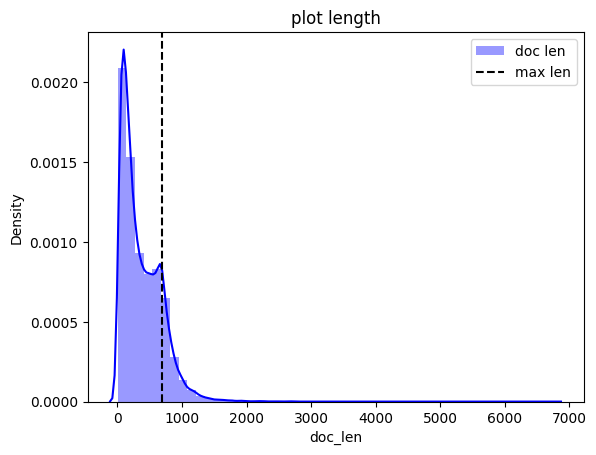

In [4]:
# TODO: it would be interesting to analyse this plot
df['doc_len'] = df['Plot'].apply(lambda words: len(words.split()))
max_seq_len = np.round(df['doc_len'].mean() + df['doc_len'].std()).astype(int)
sns.distplot(df['doc_len'], hist=True, kde=True, color='b', label='doc len')
plt.axvline(x=max_seq_len, color='k', linestyle='--', label='max len')
plt.title('plot length'); plt.legend()
plt.show()

In [5]:
# import the model you want to be use
# from sentence_transformers import SentenceTransformer
# model = SentenceTransformer('msmarco-distilbert-base-dot-prod-v3')

# store embeddings index

# PROBLEM: creating the embeddings take a lot of time. For this reason I will reduce the size of the data from 3k to 100.
df_short = df[0:100]

import faiss
encoded_data = model.encode(df_short.Plot.tolist())
encoded_data = np.asarray(encoded_data.astype('float32'))
print(encoded_data)
index = faiss.IndexIDMap(faiss.IndexFlatIP(768))
index.add_with_ids(encoded_data, np.array(range(0, len(df_short))))
faiss.write_index(index, 'movie_plot.index')

[[ 0.02067142  0.33920652 -0.268573   ...  0.3175822  -0.4776796
  -0.27488667]
 [-0.09493346 -0.00954733 -0.3790629  ...  0.44613332 -0.9814501
   0.14715911]
 [ 0.33530116 -0.2131094  -0.68906343 ...  0.14131138 -0.6853136
   0.14905608]
 ...
 [ 0.18668652  0.23521179 -0.20946929 ...  0.51503426 -0.6404393
   0.07769164]
 [ 0.0020439  -0.1803374  -0.43841067 ...  0.28032202 -0.66157985
  -0.07407728]
 [ 0.06688607  0.34058136 -0.30187997 ...  0.1086652  -0.23358256
  -0.2930713 ]]


## Problem w/ FAISS
Theoretically 'faiss' should be installed with 'faiss-gpu' but it did not work for me. Somehow the system was not able to detect 'swig' even thought it's even installed inside the 'venv'. To overcome this issue I used to version for 'faiss-cpu' which is not ideal.

## Problem with urlib3
For some reason the latest version is not compatible with OpenSSL therefore one has to downgrade to a version earlier to 2.0. Follow the following commands (this steps can be avoided using requirements.txt):

pip uninstall urllib3
pip install 'urllib3<2.0'

In [1]:
# TODO: allow this to run
# !pip install faiss-gpu

  Using cached https://files.pythonhosted.org/packages/17/76/47d0cc8161f4bf988583a2839bb1e56baf09d6b80cfa472b9eba4d5f543b/faiss-gpu-1.7.1.post2.tar.gz
  Generating metadata for package faiss-gpu produced metadata for project name faiss-cpu. Fix your #egg=faiss-gpu fragments.
  Running setup.py install for faiss-cpu ... error
    Complete output from command /Users/uri/Desktop/Projects/JCARLO/venv/bin/python3 -u -c "import setuptools, tokenize;__file__='/private/var/folders/vy/wx4s8rtd79n9d9lh1qlpfmh00000gn/T/pip-install-gw7khda6/faiss-gpu/setup.py';f=getattr(tokenize, 'open', open)(__file__);code=f.read().replace('\r\n', '\n');f.close();exec(compile(code, __file__, 'exec'))" install --record /private/var/folders/vy/wx4s8rtd79n9d9lh1qlpfmh00000gn/T/pip-record-ztrh4r6d/install-record.txt --single-version-externally-managed --compile --install-headers /Users/uri/Desktop/Projects/JCARLO/venv/include/site/python3.7/faiss-cpu:
    running install
    running build
    running build_py
    ru

In [7]:
# HELPER FUNCTIONS

# fetch movies from FAISS directory
def fetch_movie_info(dataframe_idx):
    info = df_short.iloc[dataframe_idx]
    # info = df.iloc[dataframe_idx]
    meta_dict = dict()
    meta_dict['Title'] = info['Title']
    meta_dict['Plot'] = info['Plot'][:500]
    return meta_dict

# encodes user query
def search(query, top_k, index, model):
    t=time.time()
    query_vector = model.encode([query])
    top_k = index.search(query_vector, top_k)
    print('>>>> Results in Total Time: {}'.format(time.time()-t))
    top_k_ids = top_k[1].tolist()[0]
    top_k_ids = list(np.unique(top_k_ids))
    results =  [fetch_movie_info(idx) for idx in top_k_ids]
    return results

In [8]:
# from pprint import pprint
query="A short movie"
results=search(query, top_k=5, index=index, model=model)
print("\n")
for result in results:
    print('\t',result)

: 

### Jupyter Erorr Message (Dyeing)

FutureWarning: Supporting extra quotes around strings is deprecated in traitlets 5.0. You can use 'hmac-sha256' instead of '"hmac-sha256"' if you require traitlets >=5.
  FutureWarning,
~/Desktop/Projects/JCARLO/venv/lib/python3.7/site-packages/traitlets/traitlets.py:2502: FutureWarning: Supporting extra quotes around Bytes is deprecated in traitlets 5.0. Use '586d1a14-aa63-4f9b-8e06-d6ae10337fef' instead of 'b"586d1a14-aa63-4f9b-8e06-d6ae10337fef"'.
  FutureWarning,